# Wikipedia Web Traffic Data

The dataset is available [on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)

## Imports and reading data

We read the data and fill any non-existing values with 0, representing 0 views for the specific page on that day.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import re
from statsmodels.tsa.arima_model import ARIMA
import holidays
from sklearn import preprocessing
import time

In [3]:
original_dataset = pd.read_csv("data/train_2.csv")
original_dataset.fillna(0,inplace=True)
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## Visualising some series

In [4]:
SERIES_DAYS = range(original_dataset.shape[1]-1)
def plot_series(series, title, new_plot = True, plot_show = True, label = None):
    if new_plot:
        plt.figure(figsize=(20,10))
    plt.plot(SERIES_DAYS,series,label=label)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Views")
    if plot_show:
        plt.legend()
        plt.show()

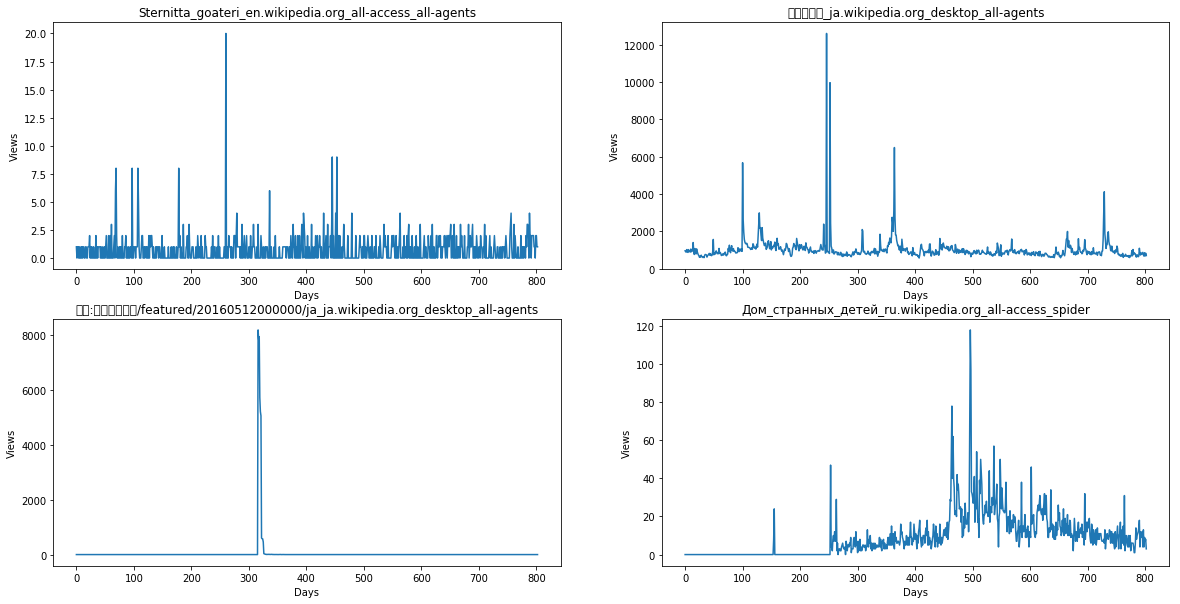

In [5]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sample = random.randint(0,original_dataset.shape[0])
    data = original_dataset.iloc[sample,1:]
    plot_series(data,original_dataset.iloc[sample,0],new_plot=False,plot_show=False)
plt.show()

## Extracting metadata

Here, we take the compound page name and extract the name of the article, the language, the type of access and the agent for each page.

In [6]:
def extract_meta(page):
    parts = page.split("_")
    [project,access,agent] = parts[-3:]
    name = " ".join(parts[0:-3])
    match_lang = re.search("([a-z][a-z])\.wikipedia\.org",project)
    lang = match_lang.group(1) if match_lang else 'na'
    return [name,lang,access,agent]

In [7]:
meta_dataset = pd.DataFrame(original_dataset)
meta_dataset['name'],  meta_dataset['lang'], meta_dataset['access'], meta_dataset['agent'] = zip(*meta_dataset['Page'].apply(extract_meta))
meta_dataset = meta_dataset[['Page', 'name', 'lang', 'access', 'agent'] + [c for c in meta_dataset if c not in ['Page', 'name', 'lang', 'access', 'agent']]]

In [8]:
print(meta_dataset['agent'].unique())
print(meta_dataset['access'].unique())

['spider' 'all-agents']
['all-access' 'desktop' 'mobile-web']


In [9]:
meta_dataset.head()

,Page,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access,spider,18.0,11.0,5.0,13.0,14.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access,spider,11.0,14.0,15.0,18.0,11.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access,spider,1.0,0.0,1.0,1.0,0.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access,spider,35.0,13.0,10.0,94.0,4.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52 Hz I Love You,zh,all-access,spider,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## Grouping page by language

Here, we split the dataset in datasets for each language, assigned in a dictionary, we also declare `plot_for_lang`, a helper function to plot the values of an index for a specific lang. We test it below by plotting a random index for a random lang.

In [10]:
sets_by_lang = {}

for lang in meta_dataset['lang'].unique().tolist():
    print(lang)
    sets_by_lang[lang] = meta_dataset[meta_dataset['lang'] == lang]
    sets_by_lang[lang].info()
    
def plot_for_lang(index,lang):
    title = sets_by_lang[lang].iloc[index,0]
    data = sets_by_lang[lang].iloc[index,5:]
    plot_series(data,title)

zh
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17229 entries, 0 to 109449
Columns: 808 entries, Page to 2017-09-10
dtypes: float64(803), object(5)
memory usage: 106.3+ MB
fr
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17802 entries, 4310 to 131932
Columns: 808 entries, Page to 2017-09-10
dtypes: float64(803), object(5)
memory usage: 109.9+ MB
en
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24108 entries, 8357 to 113950
Columns: 808 entries, Page to 2017-09-10
dtypes: float64(803), object(5)
memory usage: 148.8+ MB
na
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17855 entries, 13332 to 84734
Columns: 808 entries, Page to 2017-09-10
dtypes: float64(803), object(5)
memory usage: 110.2+ MB
ru
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15022 entries, 15882 to 127432
Columns: 808 entries, Page to 2017-09-10
dtypes: float64(803), object(5)
memory usage: 92.7+ MB
de
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18547 entries, 46371 to 141525
Columns: 808 entrie

ru 4404


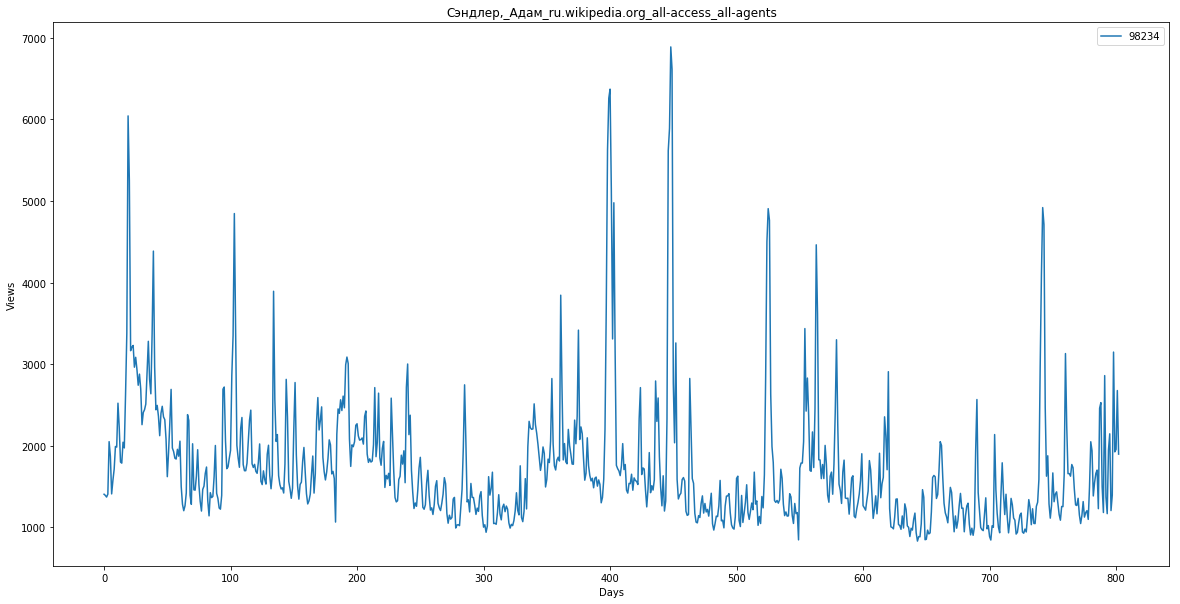

In [11]:
key = random.choice(list(sets_by_lang.keys()))
index = random.randint(0,sets_by_lang[key].shape[0])
print(key,index)
plot_for_lang(index,key)

## Aggregating data for languages

We aggregate all pages for a specific language and sum their views by days, so we get one series of the total views for each language.

In [12]:
sums_by_lang = {}
for key in sets_by_lang:
    sums_by_lang[key] = sets_by_lang[key].iloc[:,5:].sum(axis=0)

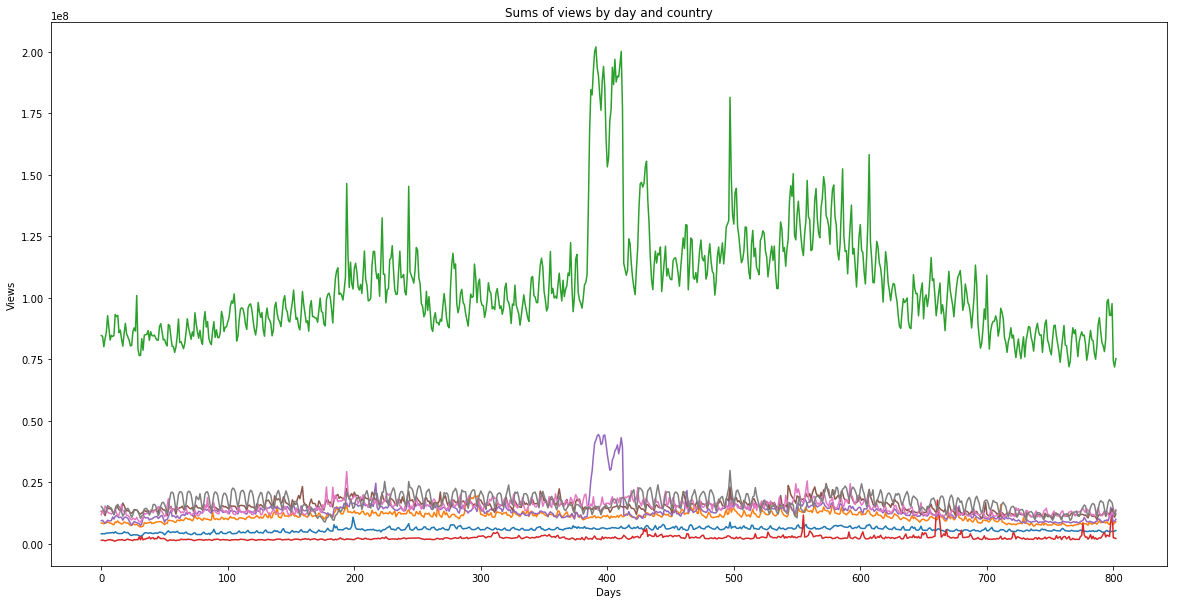

In [13]:
plt.figure(figsize=(20,10))

for key in sums_by_lang:
    plot_series(sums_by_lang[key],"Sums of views by day and country", new_plot=False,plot_show=False,label=key)
plt.show()

## Testing with fbProphet

In [14]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [15]:
full_set_prophet = sets_by_lang['es'].iloc[6922,5:]
full_set_prophet = pd.DataFrame({'ds': full_set_prophet.index.values, 'y': full_set_prophet.values})
training_size_prophet = 500
train_prophet = full_set_prophet.iloc[:training_size_prophet,:]
test_prophet = full_set_prophet.iloc[training_size_prophet:,:]

/home/matoran/Documents/master/mlbd/wikiforecasting/venv/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/matoran/Documents/master/mlbd/wikiforecasting/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, Fu

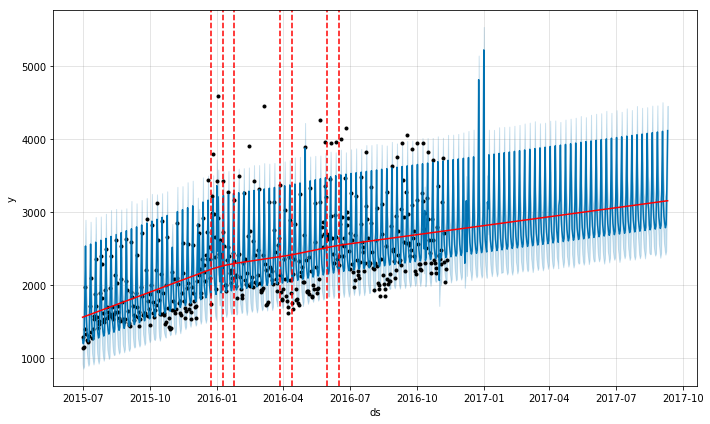

In [16]:
m_prophet = Prophet()
m_prophet.add_country_holidays(country_name='Spain')
m_prophet.fit(train_prophet)
future_prophet = m_prophet.make_future_dataframe(periods=full_set_prophet.shape[0]-training_size_prophet)
forecast_prophet = m_prophet.predict(future_prophet)
fig = m_prophet.plot(forecast_prophet)
a = add_changepoints_to_plot(fig.gca(), m_prophet, forecast_prophet)

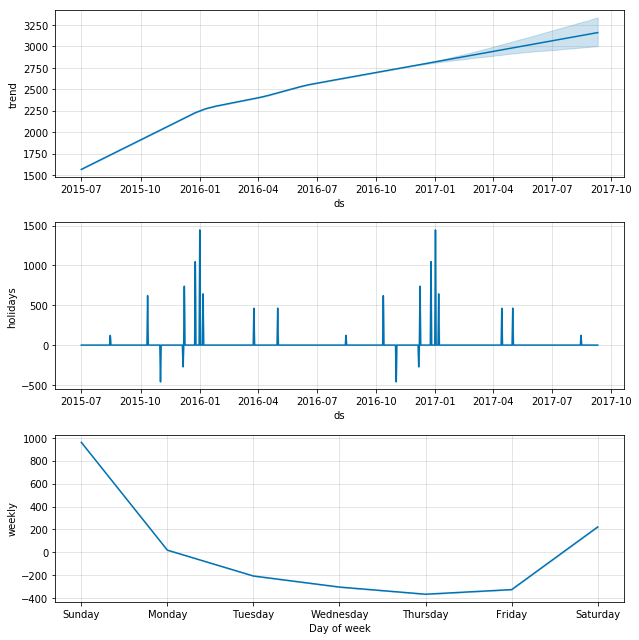

In [17]:
fig2 = m_prophet.plot_components(forecast_prophet)

/home/matoran/Documents/master/mlbd/wikiforecasting/venv/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-04-02 09:36:00 and 2017-04-02 09:36:00
/home/matoran/Documents/master/mlbd/wikiforecasting/venv/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


,horizon,mse,rmse,mae,mape,coverage
15,15 days 14:24:00,103725.814480,322.064923,276.670163,0.110439,0.6250
16,16 days 14:24:00,100213.646317,316.565390,269.063316,0.107918,0.6250
17,17 days 14:24:00,89304.094557,298.837907,245.807470,0.097529,0.6875
18,18 days 14:24:00,87220.270399,295.330781,241.338713,0.095345,0.6875
19,19 days 14:24:00,83608.405931,289.151182,229.542799,0.089521,0.6875


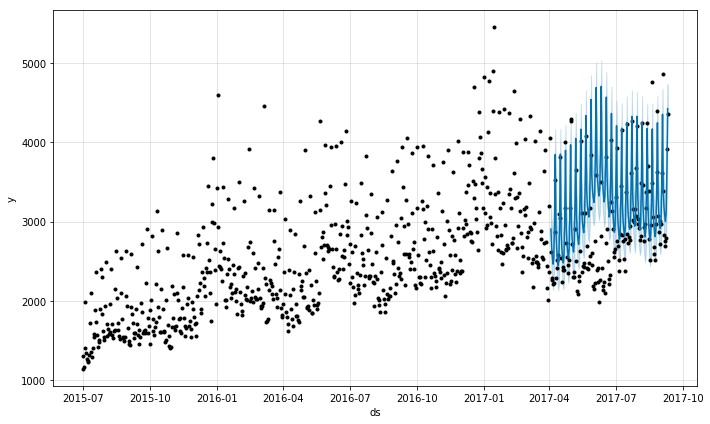

In [18]:
m_prophet_cv = Prophet()
m_prophet_cv.fit(full_set_prophet)
prophet_cv = cross_validation(m_prophet_cv, initial=f'{0.79*full_set_prophet.shape[0]} days', horizon = f'{0.2*full_set_prophet.shape[0]} days')
fig = m_prophet_cv.plot(prophet_cv)
prophet_p = performance_metrics(prophet_cv)
prophet_p.head()

## Testing ARIMA models

In [19]:
# de 72 is not bad
# na 12127
# es 1508
# fr 904
# na 9413
# en 1276
# en 23897

lang = 'na'
index = 12127
full_set = sets_by_lang[lang].iloc[index,5:]
full_set = pd.DataFrame(full_set)
full_set = full_set.values
training_size = 700
train = full_set[:training_size]
test = full_set[training_size:]

history = [x for x in train]
prediction = []


for timepoint in range(len(test)):
    y =  test[timepoint]
    #forcast value
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    y_hat = output[0]
    print(f"{timepoint + 1}/{len(test)}",end='\r')
    #add it in the list
    prediction.append(y_hat)
    history.append(y_hat)

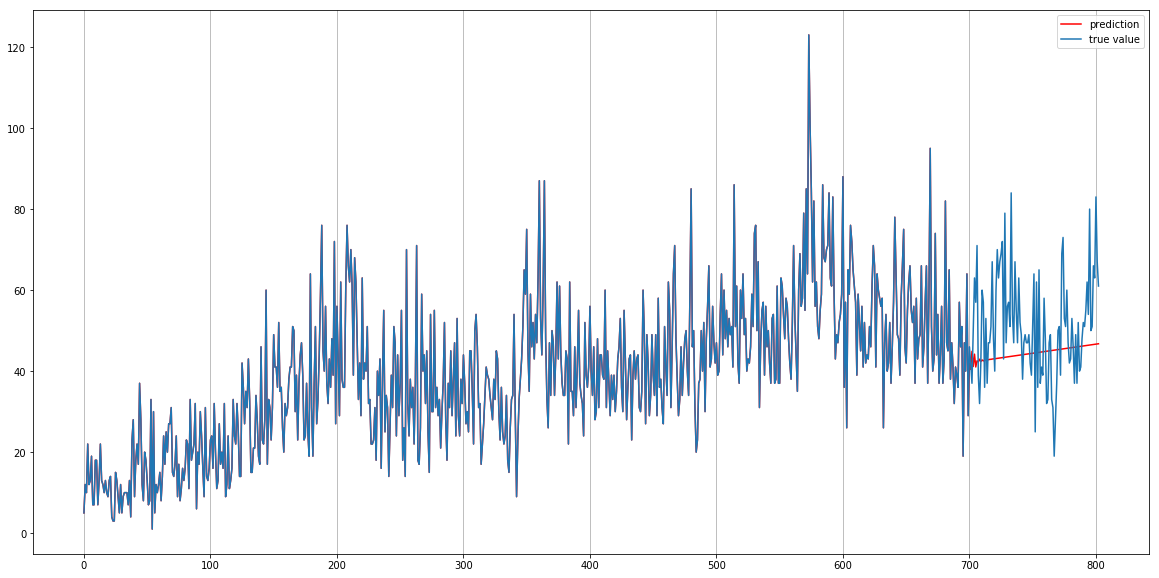

In [20]:
plt.figure(figsize=(20,10))
plot_prediction = [x for x in train] + prediction
plt.plot(plot_prediction, color='red', label='prediction')
plt.plot(full_set, label='true value')
# plt.xticks(ticks=np.arange(0,len(full_set),10))
plt.grid(axis='x',which='major')
plt.legend()
plt.show()

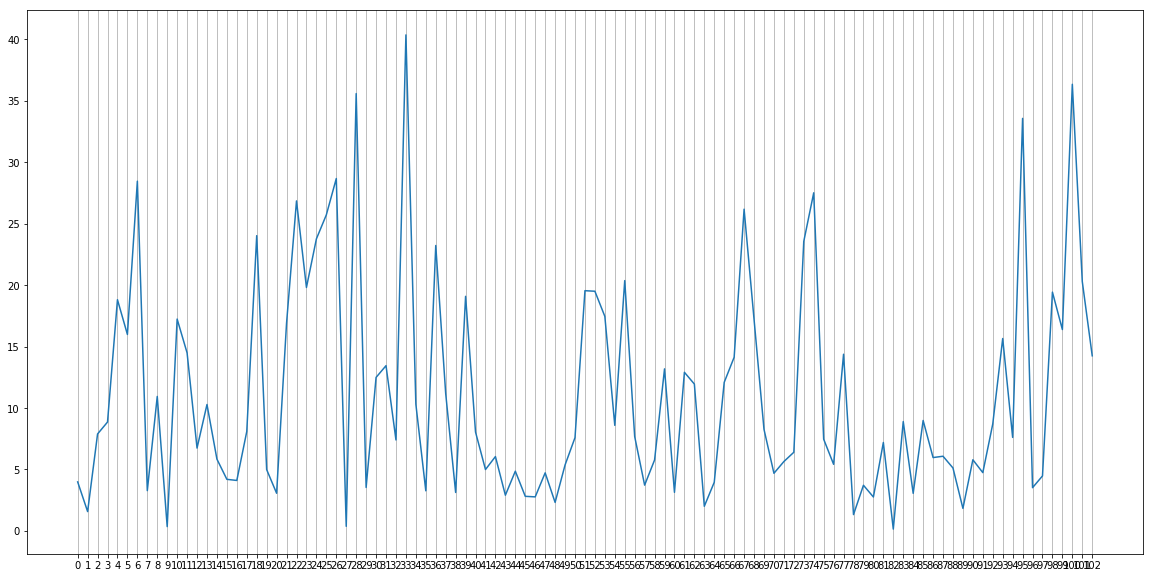

In [21]:
test_np = np.array(test)
pred_np = np.array(prediction)
absolute_diff = np.abs(test_np-pred_np)

plt.figure(figsize=(20,10))
plt.plot(absolute_diff)
plt.xticks(ticks=np.arange(0,len(test)))
plt.grid(axis='x',which='major')
plt.show()

In [22]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(test_np, pred_np)

22.460336662678134

## Extracting date features for a sample

We will try to extract date features, such as month, day of week to use them to train models. We will also use the [holidays library](https://pypi.org/project/holidays/) to add a flag for holidays in different countries for each date.

In [23]:
def extract_features(page_views):
    df = pd.DataFrame({'date': page_views.index.values, 'views': page_views.values})
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['holiday_us'] = df['date'].map(lambda x: x in holidays.UnitedStates())
    df['holiday_uk'] = df['date'].map(lambda x: x in holidays.UnitedKingdom()) 
    return df

In [24]:
index = 1
page = sums_by_lang['en']

page_with_features = extract_features(page)

holidays_days = page_with_features[page_with_features['holiday_us'] == True]
not_holidays_days = page_with_features[page_with_features['holiday_us'] == False]

print(holidays_days['views'].mean())
print(not_holidays_days['views'].mean())

110706703.28
104582137.6336761


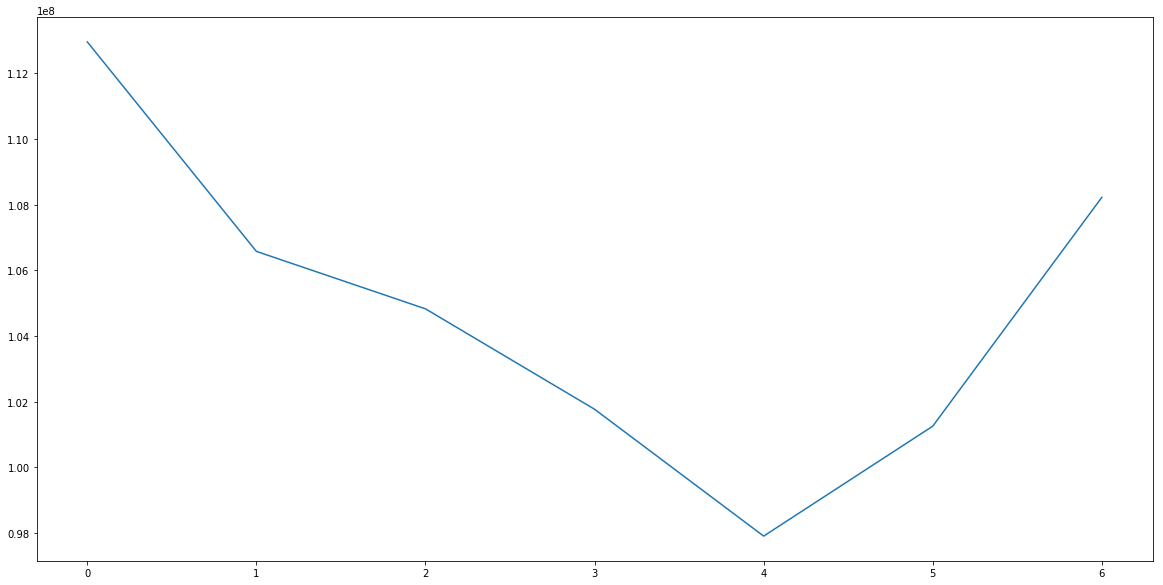

In [25]:
avg_by_day = []
for day in range(7):
    for_day = page_with_features[page_with_features['day_of_week'] == day]
    avg_by_day.append(for_day['views'].mean())

plt.figure(figsize=(20,10))
plt.plot(avg_by_day)
plt.show()

## Clustering for time-series

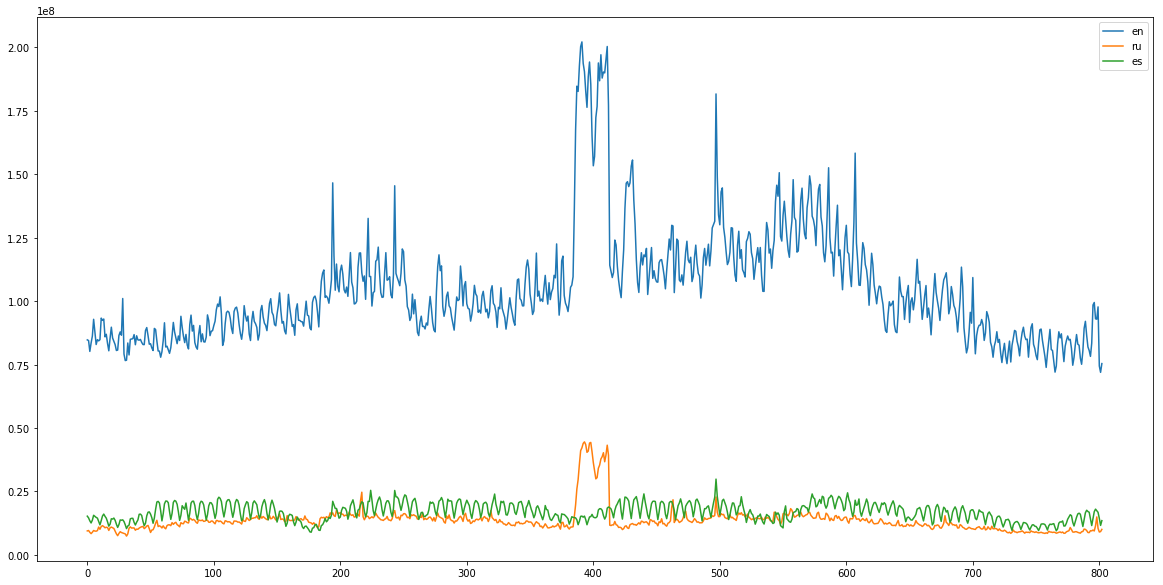

In [26]:
plt.figure(figsize=(20,10))
for lang in ['en','ru','es']:
    plt.plot(range(sums_by_lang[lang].shape[0]), sums_by_lang[lang],label=lang)
    
plt.legend()
plt.show()

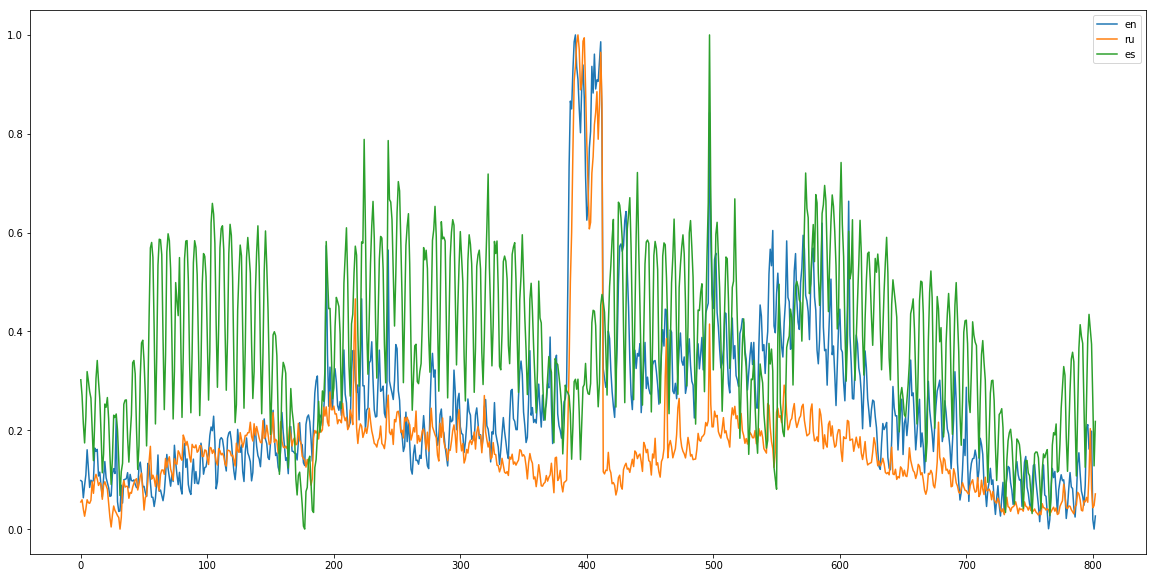

In [27]:
normalized_sets = {}
plt.figure(figsize=(20,10))
for lang in ['en','ru','es']:
    min_max_scaler = preprocessing.MinMaxScaler()
    values = np.array(sums_by_lang[lang].values)
    values = values.reshape(-1,1)
    normalized_sets[lang] = min_max_scaler.fit_transform(values)
    plt.plot(range(normalized_sets[lang].shape[0]), normalized_sets[lang],label=lang)
    
plt.legend()
plt.show()

In [28]:
from dtw import dtw,accelerated_dtw
from scipy.spatial.distance import euclidean

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(normalized_sets['en'],normalized_sets['ru'],dist='euclidean')
print(d)

0.025441248098140225


In [29]:
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(normalized_sets['en'],normalized_sets['es'],dist='euclidean')
print(d)

0.044472291922941456


In [30]:
start = time.time()
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(normalized_sets['ru'],normalized_sets['es'],dist='euclidean')
print(d)

0.05936526251515177


## Normalising the whole data set

In [31]:
min_max_scaler = preprocessing.MinMaxScaler()
data = meta_dataset.iloc[:,5:].values
data = data.transpose()
normalised = min_max_scaler.fit_transform(data)
normalised = normalised.transpose()
normalised_dataset = pd.DataFrame(meta_dataset)
normalised_dataset.iloc[:,5:] = normalised

In [32]:
normalised_dataset

,Page,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access,spider,0.030801,0.016427,0.004107,0.020534,0.022587,...,0.032854,0.061602,0.061602,0.030801,0.026694,0.049281,0.053388,0.041068,0.104723,0.071869
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access,spider,0.011057,0.014742,0.015971,0.019656,0.011057,...,0.036855,0.034398,0.011057,0.020885,0.063882,0.028256,0.029484,0.025799,0.013514,0.097052
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access,spider,0.004762,0.000000,0.004762,0.004762,0.000000,...,0.028571,0.028571,0.033333,0.009524,0.019048,0.033333,0.014286,0.019048,0.033333,0.028571
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access,spider,0.112583,0.039735,0.029801,0.307947,0.009934,...,0.019868,0.059603,0.059603,0.026490,0.016556,0.049669,0.059603,0.096026,0.122517,0.009934
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52 Hz I Love You,zh,all-access,spider,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068376,0.068376,0.081197,0.038462,0.085470,0.098291,0.119658,0.059829,0.034188,0.029915
5,5566_zh.wikipedia.org_all-access_spider,5566,zh,all-access,spider,0.051887,0.028302,0.014151,0.018868,0.089623,...,0.056604,0.056604,0.207547,0.014151,0.056604,0.089623,0.080189,0.075472,0.061321,0.047170
6,91Days_zh.wikipedia.org_all-access_spider,91Days,zh,all-access,spider,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099174,0.066116,0.041322,0.057851,0.066116,0.082645,0.066116,0.041322,0.024793,0.041322
7,A'N'D_zh.wikipedia.org_all-access_spider,A'N'D,zh,all-access,spider,0.225434,0.048170,0.055877,0.044316,0.053950,...,0.140655,0.073218,0.019268,0.104046,0.134875,0.082852,0.046243,0.073218,0.046243,0.094412
8,AKB48_zh.wikipedia.org_all-access_spider,AKB48,zh,all-access,spider,0.000000,0.052326,0.026163,0.020349,0.011628,...,0.139535,0.296512,0.168605,0.107558,0.055233,0.113372,0.081395,0.136628,0.046512,0.125000
9,ASCII_zh.wikipedia.org_all-access_spider,ASCII,zh,all-access,spider,0.038835,0.009709,0.029126,0.097087,0.038835,...,0.174757,0.135922,0.194175,0.165049,0.184466,0.291262,0.310680,0.262136,0.203883,0.223301


In [47]:
# NOT POSSIBLE TO run clustering with DTW for all pairs, gotta run for 1000*1000 pairs and then do normal distances
def register_bindings():

    from prompt_toolkit.keys import Keys
    from prompt_toolkit.key_binding.bindings.completion import generate_completions

    bind_key = ip.pt_cli.application.key_bindings_registry.add_binding
    bind_key(Keys.ControlSpace)(generate_completions)

ip = get_ipython()
if getattr(ip, "pt_cli"): register_bindings()
del register_bindings
a

AttributeError: 'ZMQInteractiveShell' object has no attribute 'pt_cli'

In [64]:
from dtaidistance import dtw
import numpy as np
a = sets_by_lang['en'].iloc[:15,5:].values.astype(np.float)
ds = dtw.distance_matrix_fast(a, show_progress=True)

print(ds)

for i in range(ds.shape[0]):
    for j in range(i, ds.shape[1]):
        if i == j: 
            ds[i][i] = 0
        elif i < j:
            ds[j][i] = ds[i][j]
            
        

from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5, linkage="complete", affinity="precomputed").fit(ds)
clustering.labels_

INFO:be.kuleuven.dtai.distance:Computing distances
INFO:be.kuleuven.dtai.distance:Compute distances in pure C (parallel=True)


[[             inf 1962850.05818172  583989.96138461 1761069.31422077
  1937145.73651545 1804016.41555281 1662718.63726218 1956958.05186902
  1847340.73290203 1188750.14433227 1687269.63587863 1396416.83350567
  1976813.92641948 1942530.98395109 2009397.32542944]
 [             inf              inf 2013755.21206228  252151.53577165
    32963.91420933  199602.28062575  167457.12163715   44795.89503515
    75615.10345163  441501.81967349  153550.38958596  315933.88634175
    29892.30896067   19363.7509796    32271.92566303]
 [             inf              inf              inf 1862004.91548438
  1994372.62177834 1901844.55872529 1782668.5906612  2010276.46665502
  1926070.04899173 1394651.89677926 1801904.08258459 1570007.93248123
  2024255.03986405 1998344.26797086 2048599.50991378]
 [             inf              inf              inf              inf
   236825.04866673  241205.98134167  239679.51989271  242485.38145216
   235180.04482098  393981.19174016  227927.44830318  309268.872294


array([2, 1, 3, 0, 1, 0, 1, 1, 1, 4, 1, 4, 1, 1, 1])